In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import bernoulli
import time

In [2]:
data = pd.read_csv('breast_cancer_wisconsin_dset.csv', index_col=False)

In [3]:
Y = data['diagnosis'].values
X = data.drop('diagnosis', axis=1).values
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=20)

In [4]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = SVC(C=2.0, kernel='rbf',probability=True)
model.fit(X_train_scaled, Y_train)
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)
print("Accuracy score %f" % accuracy_score(Y_test, predictions))

Accuracy score 0.991228


In [12]:
def compute_fitness(model, x_adv, targetlabel):
    return model.predict_proba([x_adv])[0, targetlabel]

def mutation(xx, delta,  rho):
        noise = np.random.uniform(low = -delta, high = delta, size=xx.shape)
        idx_to_apply = bernoulli.rvs(size=xx.shape, p = rho)
        x_adv = xx + idx_to_apply*noise
        return x_adv

def breed(parent1, parent2, fitness1, fitness2):
    total_fitness = fitness1 + fitness2
    sampling_input = [fitness1/(total_fitness), fitness2/(total_fitness)]
    cumsum_si = np.cumsum(sampling_input)
    child = parent2
    for i in range(len(parent1)):
        #"flip a weighted coin" to take gene from a parent
        deviate = np.random.uniform(0.0, 1.0)
        index = np.where(cumsum_si > deviate)[0][0]
        if index == 0:
            child[i] = parent1[i]
    return child

#Function to sample from a probability distribution
def sampling(probs):
    probs_cumsum = np.cumsum(probs)
    deviate = np.random.uniform(0.0, 1.0)
    index = np.where(probs_cumsum > deviate)[0][0]
    return index

def genetic_attack(model, x, delta, rho, pop_size, num_of_generations, targetlabel):
    score_history = []
    population = [[0 for i in range(pop_size)] for g in range(num_of_generations)]
    fitnesses = np.zeros((num_of_generations, pop_size))
    
    #create initial population
    for i in range(0, pop_size):
        population[0][i]  = mutation(x, delta, rho) 

    #start evolution
    for g in range(1, num_of_generations):
        
        #compute fitness of last generations population
        for i in range(0, pop_size):
            fitnesses[g-1, i] = compute_fitness(model, population[g-1][i], targetlabel)
        
        #find fittest member in last generation
        adv_pop_idx = np.argmax(fitnesses[g-1])
        score_history.append(fitnesses[g-1][adv_pop_idx])
        x_adv = population[g-1][adv_pop_idx]
        #if fittest member is fit enough, stop algorithm, otherwise continue
        if g % 1000 == 0:
            print('cur_gen:%d, cur_score:%.5f' %(g, fitnesses[g-1][adv_pop_idx]))
        if (model.predict_proba([x_adv])[0,targetlabel] > .5):
            return score_history
        
        #add fittest member to next generation
        population[g][0] = x_adv       
        
        #breed children from fit parents for next generation
        probs = fitnesses[g-1, :]/(fitnesses[g-1, :].sum())
        
        for i in range(1, pop_size):
            parent_1_idx = sampling(probs)
            parent_2_idx = sampling(probs)
            parent_1 = population[g-1][parent_1_idx]
            parent_2 = population[g-1][parent_2_idx]            
            child = breed(parent_1, parent_2, fitnesses[g-1, parent_1_idx], fitnesses[g-1, parent_2_idx])
            #mutate the child before adding to next generation
            population[g][i] = mutation(child, delta, rho)
            
    return score_history

In [13]:
score_history = genetic_attack(model, X_train_scaled[0], .01, .1, 100, 10000, 1)

cur_gen:1000, cur_score:0.00175
cur_gen:2000, cur_score:0.00699
cur_gen:3000, cur_score:0.02623
cur_gen:4000, cur_score:0.06933
cur_gen:5000, cur_score:0.14252
cur_gen:6000, cur_score:0.27755
cur_gen:7000, cur_score:0.39967
cur_gen:8000, cur_score:0.50000


Text(0.5, 0, 'Generation')

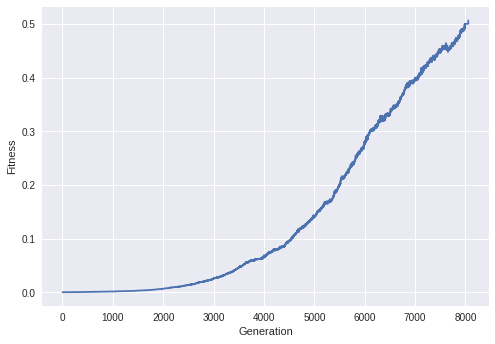

In [15]:
plt.style.use('seaborn')
plt.plot(list(range(len(score_history))),score_history)
plt.ylabel("Fitness")
plt.xlabel("Generation") 